# 부트스트랩

데이터를 가져오거나 필요한 라이브러리를 임포트한다.

## 동작 환경 소개
이 노트북은 처음부터 **캐글**에서 작성되어 **캐글**에서 동작하도록 되어 있습니다.
동작환경에 때라 의족성 라이브러리 설치 및 데이터 파일 위치등을 수정해야할 수 있습니다.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import missingno as msno
import seaborn as sns

import xgboost as xgb
import lightgbm as lgb
import missingno

import pandas as pd
import numpy as np

# AttributeError: module 'sklearn' has no attribute 'ensemble' 이슈 해결
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score

import os

print('done')

done


In [2]:
# 데이터 디렉토리가 있는지 파악하고 없으면 다운로드
if os.path.exists('/kaggle/working/data'):
    print('exist')
else:
    !wget "https://d3s0tskafalll9.cloudfront.net/media/documents/kaggle-kakr-housing-data.zip"
    !ls
    !unzip -o kaggle-kakr-housing-data.zip

    !pwd
    !ls ./data -alG

--2023-05-20 13:38:12--  https://d3s0tskafalll9.cloudfront.net/media/documents/kaggle-kakr-housing-data.zip
Resolving d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)... 52.84.160.162, 52.84.160.195, 52.84.160.126, ...
Connecting to d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)|52.84.160.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 693719 (677K) [application/zip]
Saving to: ‘kaggle-kakr-housing-data.zip’

kaggle-kakr-housing 100%[===================>] 677.46K  --.-KB/s    in 0.02s   

2023-05-20 13:38:12 (27.2 MB/s) - ‘kaggle-kakr-housing-data.zip’ saved [693719/693719]

__notebook_source__.ipynb  kaggle-kakr-housing-data.zip
Archive:  kaggle-kakr-housing-data.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          
/kaggle/working
total 2368
drwxr-xr-x 2 root    4096 May 20 13:38 .
drwxr-xr-x 4 root    4096 May 20 13:38 ..
-rwxrwxr-x 1 root   84093 Jun 15  202

In [3]:
# 파일 경로 설정
data_root_path = "/kaggle/working/data"
train_data_path = f"{data_root_path}/train.csv"
test_data_path = f"{data_root_path}/test.csv"
print(train_data_path)
print(test_data_path)

/kaggle/working/data/train.csv
/kaggle/working/data/test.csv


## 데이터 설명 백업
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [4]:
# csv로부터 데이터 프레임 생성
original = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# 만약을 위해 일단 백업
# 주로 data를 다룰 것임
data = original.copy()

# 형태를 파악, 아마도 target이 없는 것 빼곤 동일한 컬럼수
data.shape, test_data.shape

((15035, 21), (6468, 20))

In [5]:
# y 데이터 생성
y = data['price']
del data['price']
y.head()

0    221900.0
1    180000.0
2    510000.0
3    257500.0
4    291850.0
Name: price, dtype: float64

In [6]:
# 경향성 파악을 위해 테스트 데이터 결합
train_len = len(data)
data = pd.concat((data, test_data), axis=0)
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


# 전처리

1. Missing data
2. 불필요한 컬럼 제거
3. Normalization
4. 
5.

## Missing Data

<AxesSubplot: >

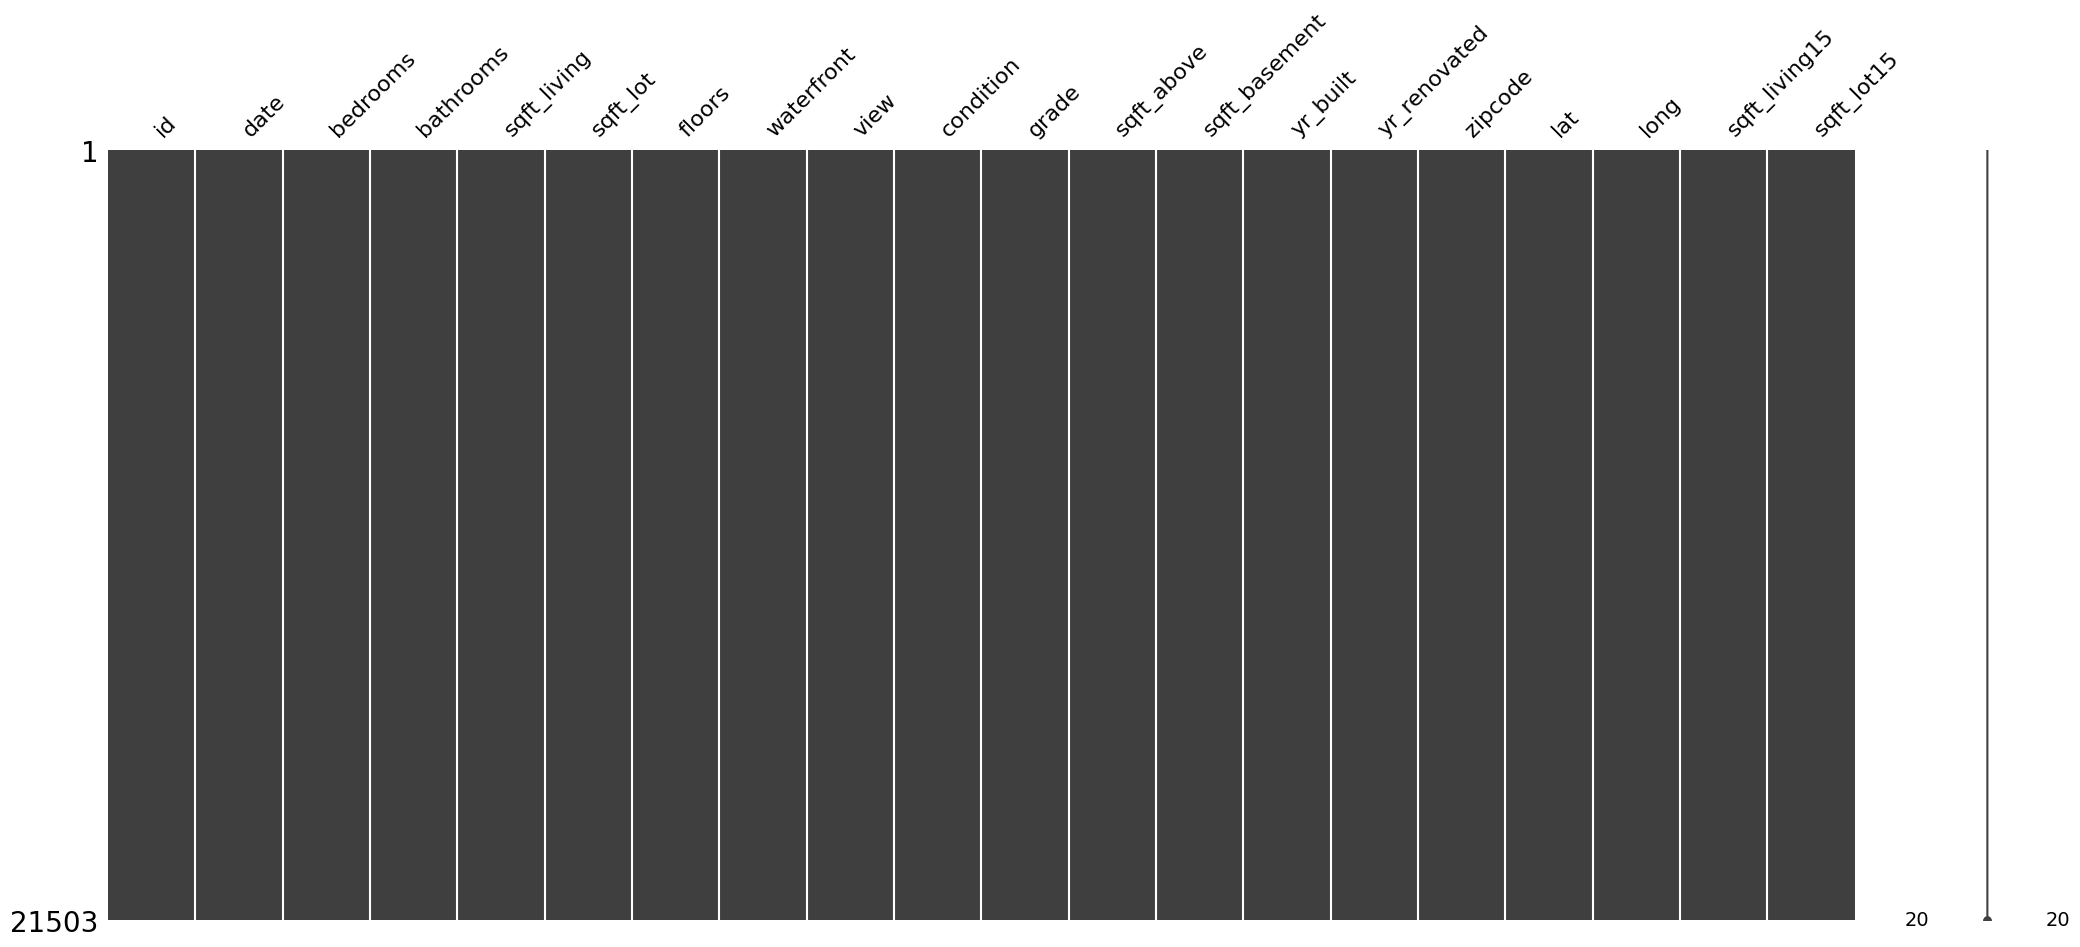

In [7]:
# Missing data 여부를 그래프로 확인
msno.matrix(data)

In [8]:
# Missing data 여부를 수치로 확인
for c in data.columns: # df.loc[행 인덱싱값, 열 인덱싱값]
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))
    
# ref: https://datascienceschool.net/01%20python/04.03%20%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%94%84%EB%A0%88%EC%9E%84%20%EA%B3%A0%EA%B8%89%20%EC%9D%B8%EB%8D%B1%EC%8B%B1.html?highlight=%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%94%84%EB%A0%88%EC%9E%84%20%EA%B3%A0%EA%B8%89%20%EC%9D%B8%EB%8D%B1%EC%8B%B1

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


## 불필요한 컬럼 제거 - id

In [9]:
# 불필요한 컬럼 제거
# 일단 관련도가 적은 id를 제거하고, date컬럼을 수정한다.

# 제출데이터를 위해 백
sub_id = data['id'][train_len:]
del data['id']

# 람다 설명: date는 20141013T000000과 같은 형태이다. 
# 우리는 연과 월을 합쳐서 범주형을 만들것임으로 처음에서 6번째 글자만
# 슬라이싱하도록 한다.
data['date'] = data['date'].apply(lambda x: str(x[:6])).astype(int)
print("done")

done


## Normalization

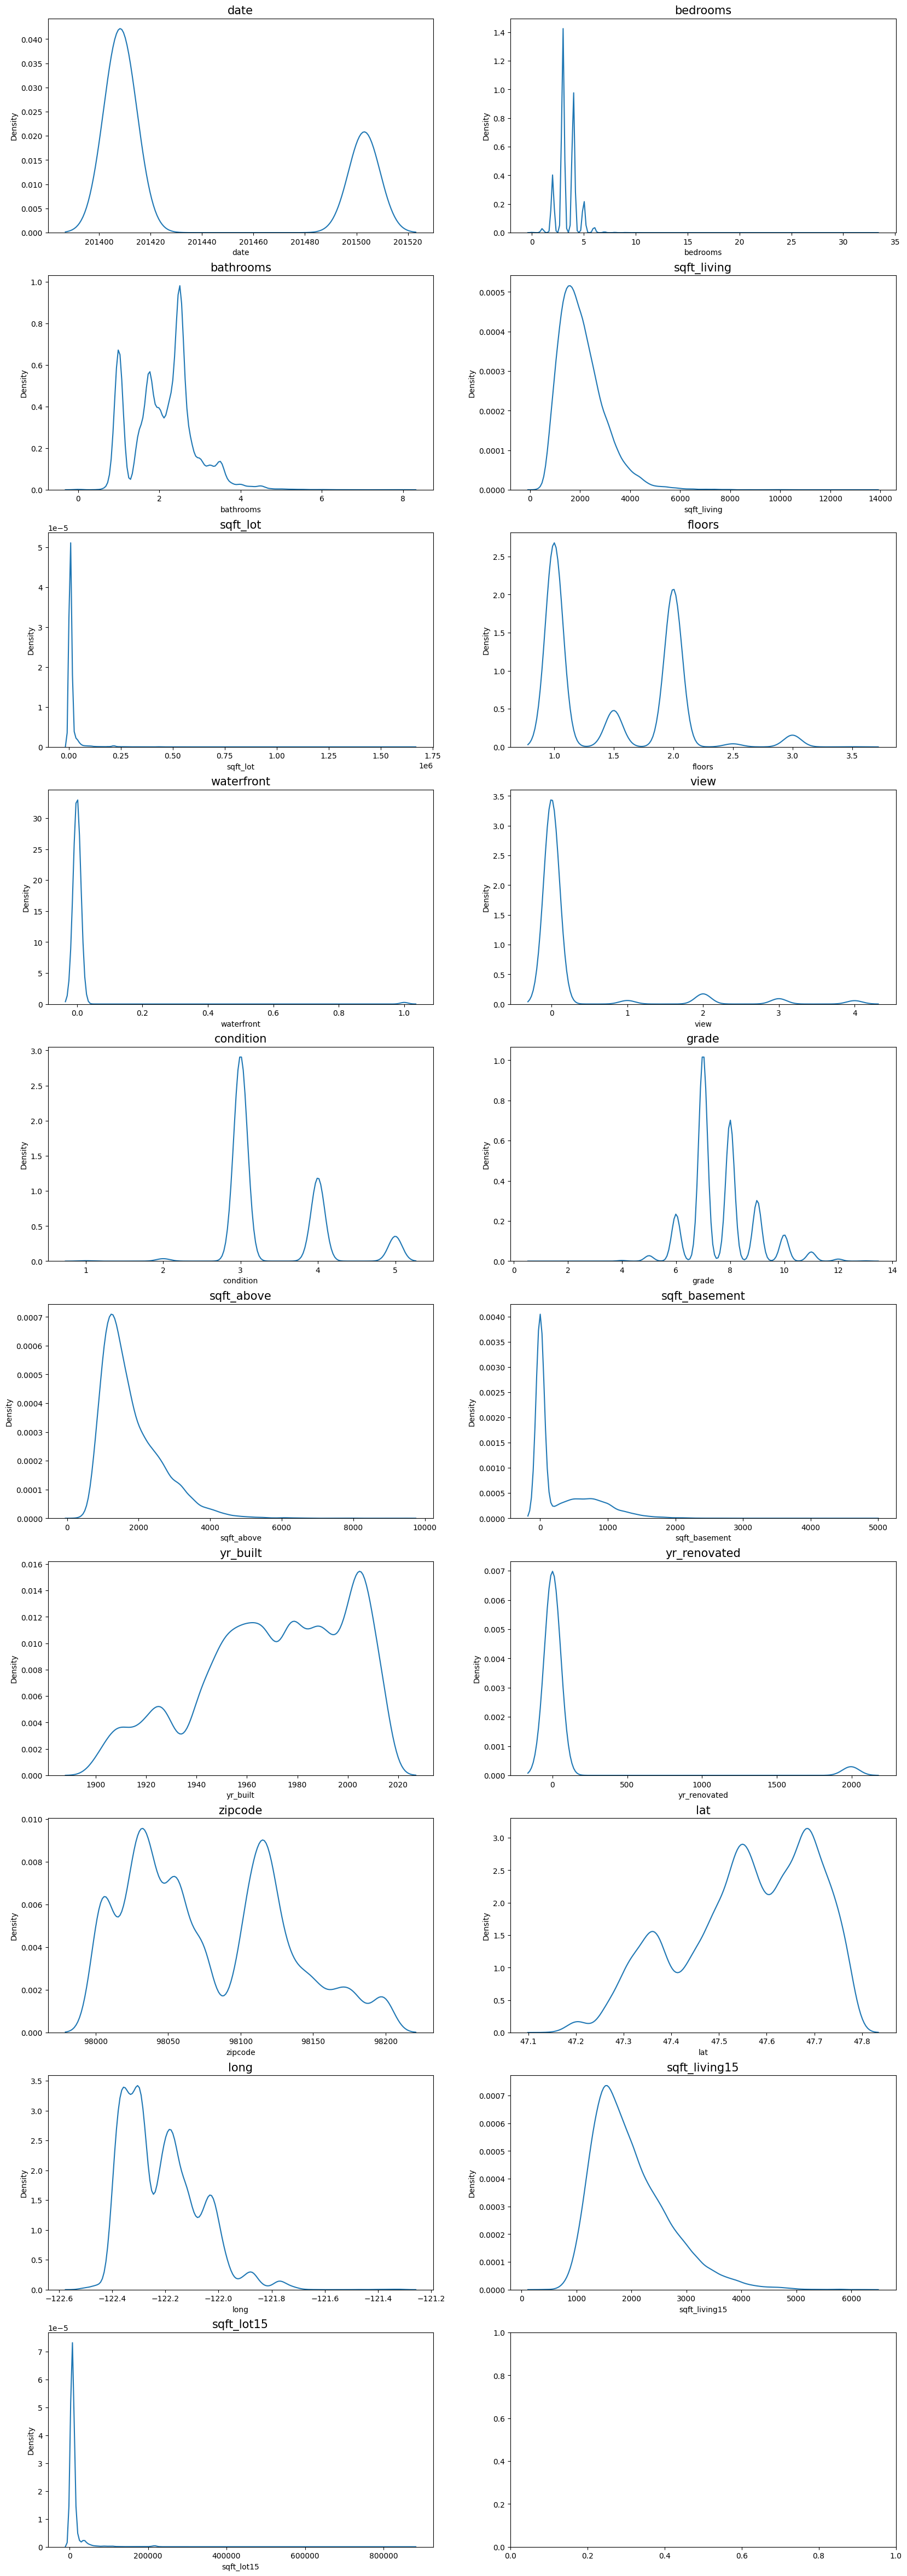

In [10]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        try:
            sns.kdeplot(data[columns[count]], ax=ax[row][col])
        except:
            print(columns[count])
        
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break


In [11]:
# 한쪽으로 치우친 컬럼들을 로그 스케일링으로 보정한다.
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
for c in skew_columns:
    data[c] = np.log1p(data[c].values)

    

<AxesSubplot: xlabel='price', ylabel='Density'>

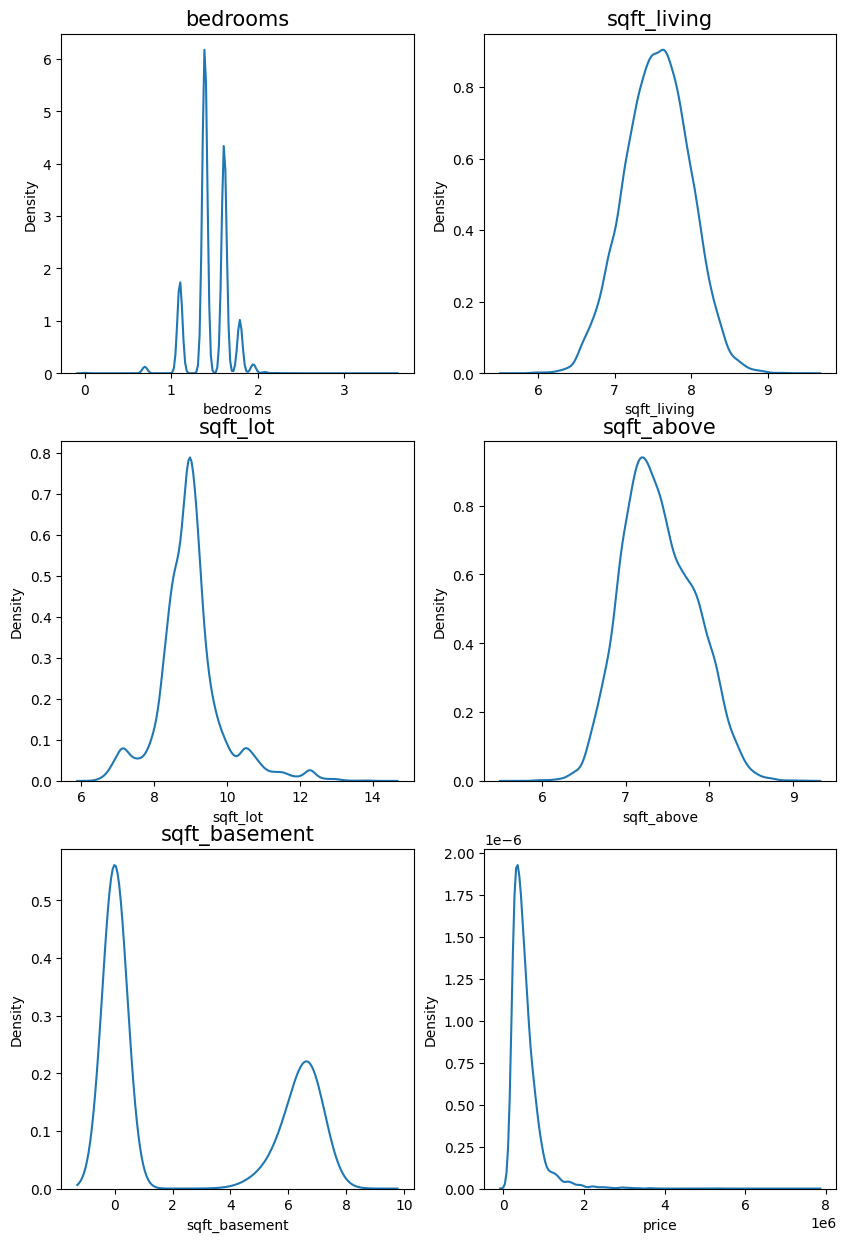

In [12]:
# 같은 작업을 통해 재대로 적용됬는지 확인
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1
        
sns.kdeplot(y, ax=ax[2][1])


In [13]:
# 데이터 다시 분리하기
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

# 모델링

Average Blending 모델을 구현한다.
Because 회귀모델이기 때문에 Voting보다는 Average blending이 더 적절하기 때문.

In [14]:
from sklearn.ensemble import RandomForestRegressor

# 모델 설정
# GreadSearch 대신 수동으로 조율 했음. (더 느려서)
gboost = GradientBoostingRegressor(
    random_state=42, # 일정한 결과 도출을 위한 시드
    learning_rate=0.2, # 학습률
    n_estimators=250 # 트리 개수
)
xgboost = xgb.XGBRegressor(
    random_state=42, 
    n_estimators=130, 
    learning_rate=0.2,
    max_depth=5 # 최대 깊이
)
lightgbm = lgb.LGBMRegressor(
    random_state=42, 
    max_depth=14, 
    n_estimators=150
)

models = [
    {'model':gboost, 'name':'GradientBoosting'}, 
    {'model':xgboost, 'name':'XGBoost'},
    {'model':lightgbm, 'name':'LightGBM'}
]

print('done')

done


In [15]:
# cv score 계산하기
def get_cv_score(models):
    kfold = KFold(n_splits=5, shuffle=True, random_state=2023).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                             kf=kfold))
print('done')

done


In [16]:
# 함수 호출
get_cv_score(models)

Model GradientBoosting CV score : 0.8860
Model XGBoost CV score : 0.8937
Model LightGBM CV score : 0.8830


# 제출 파일 생성

In [17]:
# 회귀 문제를 위한 Averaging Blending
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [18]:
# 예측
y_pred = AveragingBlending(models, x, y, sub)

In [19]:
# 후가공
sub_out = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [20]:
# 출력
sub_out.to_csv('submission9.csv', index=False)
print('done')

done


# 단일 모델로 테스트

In [34]:
# LGBMRegressor 모델 단일 실험
model = lgb.LGBMRegressor(learning_rate=0.01,# 변경 1
                          max_depth=20,
                          num_leaves=18,
                          n_estimators=10000, # 변경 2
                          random_state=42,
                          boosting_type='goss') # 변경 3

# kfold test
kfold = KFold(n_splits=5, shuffle=True, random_state=2023).get_n_splits(x.values)
print("CV score : {:.4f}".format(np.mean(cross_val_score(model, x.values, y)), kf=kfold))

# fit
model.fit(x, y)

CV score : 0.8986


LGBMRegressor(boosting_type='goss', learning_rate=0.01, n_estimators=10000,
              num_leaves=18, random_state=42)

In [35]:
# 출력
pred = model.predict(sub.values)
sub2 = pd.DataFrame(data={'id':sub_id,'price':pred})

sub2.to_csv('submission11.csv', index=False)
print('done')

done


# 결과
앙상블
![](https://github.com/crlotwhite-mirror/AiffelOnline4/blob/main/Exploration/Node2/result1.png?raw=true)

단일 모델
![](https://github.com/crlotwhite-mirror/AiffelOnline4/blob/main/Exploration/Node2/result2.png?raw=true)

단일 모델을 통해 목표 점수 달성함
106929.77179